## Notebook for Figure 4

In [1]:
%matplotlib inline

from tqdm.notebook import tqdm
import os 
import requests

import xarray as xr
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patches as patches
import cartopy.crs as ccrs

from one_pass import __version__ as one_pass_version
from one_pass.opa import Opa
from utils import read_or_download_dataset

from crick import TDigest

print(f"One_Pass version: {one_pass_version}")

One_Pass version: 0.8.0


Load data and extract wind speed. 

The wind speed has been calculated using the square root of the sum of the two horizontal wind components from the IFS model, run as part of the nextGEMS cycle 3 runs.

Showing hourly data over December 2020.

We have re-sampled the data down to r100 for usabiltiy: this allows us to demonstrate the streaming algorithms by loading all the data in memory and then looping through.

In operational mode this would done via an automated workflow manager or similar that would pass higher resolution data to the algorithms chunk by chunk.

In [2]:
# Download data if not present

URLS = (
    ("ws_2020.nc", "https://zenodo.org/records/12533197/files/wind_speed_dec_2020_IFS_tco2559_ng5_cycle3_r100.nc?download=1"),
    ("ws_2020_texas.nc", "https://zenodo.org/records/12533197/files/wind_speed_dec_texas_IFS_tco2559_ng5_cycle3_r010.nc?download=1"),
    ("ws_2020_uk.nc", "https://zenodo.org/records/12533197/files/wind_speed_dec_uk_IFS_tco2559_ng5_cycle3_r010.nc?download=1"),
)

ws = read_or_download_dataset(*URLS[0])["wind_speed_rms_u10_v10"]
ws_texas = read_or_download_dataset(*URLS[1]).to_dataarray().data
ws_uk = read_or_download_dataset(*URLS[2]).to_dataarray().data

Reading: data/ws_2020.nc
Reading: data/ws_2020_texas.nc
Reading: data/ws_2020_uk.nc


We use the `Opa` class to compute the percentile statistic over the incoming stream of data. We simulate the stream of data by looping over the timesteps, selecting different chunks and feeding them to the `Opa` class. We use a weight of 4 for each data chunk.

In [3]:
quantiles = np.linspace(0, 100, 101)

In [4]:
# extract data array

step = 4

opa_stat = Opa({
    "variable": "wind_speed_rms_u10_v10",
    "stat": "percentile",
    "percentile_list": (quantiles / 100).tolist(),
    "stat_freq": "monthly",
    "output_freq": "monthly",
    "compression": 60,
    "time_step": 60,  # minutes
    "checkpoint": False,
    "save": False,
})

# simulating the streamed data
for hour in tqdm(range(0, len(ws.time), step)):
    incoming_data_chunk = ws.isel(time = slice(hour, hour+step))
    result = opa_stat.compute(incoming_data_chunk)

size_data_source_tail = np.size(incoming_data_chunk.tail(time=1))

  0%|          | 0/186 [00:00<?, ?it/s]

We now want to calculate the estimated value of each percentile from using the t-digest comapred to the estimate from using numpy. 

Here we calculate the numpy estimate for every percentile value over the spatial grid (we flatten the array to match the shape of the digest list)

In [5]:
# list of quantiles we want to loop thorugh
# empty array that will story all the numpy percentile estimates for every grid cell
percen_numpy = np.zeros([len(quantiles), size_data_source_tail])
# flattening the array over the spatial grid
ws_flat = np.reshape(ws.values, [len(ws.time), size_data_source_tail])
# going through every quantile 
for index, quantile in tqdm(enumerate(quantiles), total=len(quantiles)):
    percen_numpy[index, :] = np.percentile(ws_flat, axis=0, q=quantile, method = 'linear')

  0%|          | 0/101 [00:00<?, ?it/s]

We now compare the numpy estimate against the estimate produced by the `Opa` class and provide the error as a percentage of the numpy value

In [6]:
percen_opa = result["wind_speed_rms_u10_v10"].values[0, :, :, :].reshape(len(quantiles), -1)
time_dim, lat_size, lon_size = np.shape(incoming_data_chunk)

per_error = ((percen_opa - percen_numpy)/percen_numpy) * 100        

# averaging the error across all the percentiles
average_error = np.mean(abs(per_error), axis = 0)

# reshape array back to lat lon
total_per_error = np.reshape(average_error, [1, lat_size, lon_size])

We define a helper function `get_index_lat_lon`, to retrieve the latitude and longitude indices that correspond to a given latitude and longitude.

In [7]:
def _get_closest_value(sequence, value):
  array = np.asarray(sequence)
  index = (np.abs(array - value)).argmin()
  return array[index]

def get_index_lat_lon(ds, lat, lon):

    # We first get the closest latitude and lotitude that does exist in the dataset.
    closest_lat = _get_closest_value(ds.lat.values, lat)
    closest_lon = _get_closest_value(ds.lon.values, lon)

    # We then select the location of the index that matches with the closest value computed.
    index_lat = np.where(ds.lat.values == closest_lat)[0][0]
    index_lon = np.where(ds.lon.values == closest_lon)[0][0]

    return index_lat, index_lon

The time series for the Moray East wind farm (North Sea) and the Rosoe wind farm (Texas, North America) were already loaded at the top of the notebook. These time series were extracted from the native resolution data to be more accurate with the location. If you want to change the location of these points to examine different locations, uncomment the code below (`ws_uk` or `ws_texas`) to select data from the downsampled dataset

Here we match the co-ordinates of the two wind farm locations to their closest location on the overall wind speed dataset to allow for plotting. 

In [8]:
# target lat and lon for the Moray East wind farm
uk_latlon = (58.25, 2.75)
uk_latlon_index = get_index_lat_lon(ws, *uk_latlon)
# ws_uk = ws[:, uk_latlon_index[0], uk_latlon_index[1]]

# target lat and lon for the Roscoe wind farm
texas_latlon = (32.35, 360 - 100.55)
texas_latlon_index = get_index_lat_lon(ws, *texas_latlon)
# ws_texas = ws[:, texas_latlon_index[0], texas_latlon_index[1]]

Here, we are using these two specific locations to evaluate the effect of the compression parameter on the t-digest estimate. We again use the package `TDigest`, which is internally used in the `Opa` class in order to examine the number of centroids.

In [9]:
quantiles = [50, 80]

# min and max compression factors to span across
max_comp = 140
min_comp = 20
compression_spacing = 2
spacing = int((max_comp - min_comp) / compression_spacing) + 1
compressions = np.linspace(min_comp, max_comp, spacing)

tdigest_list_uk = []
tdigest_list_texas = []

for compression in compressions:
    tdigest_uk = TDigest(compression=compression)
    tdigest_texas = TDigest(compression=compression)

    # simulating streaming by adding data to the digests incrementally
    for j in range(len(ws_uk)):
        tdigest_uk.update(ws_uk[j])
        tdigest_texas.update(ws_texas[j])

    tdigest_list_uk.append(tdigest_uk)
    tdigest_list_texas.append(tdigest_texas)

Here we are calcluating the difference between the numpy and t-digest estimates for these two specfic locations based on the full range of compression factors. We then conduct a detailed analysis for the 50th and 80th percentile, comparing with the range of estimates obtained from using different numpy interpolation schemes.

In [10]:
# specific quantiles to examine

datasets = (ws_uk, ws_texas)
methods = (
    'inverted_cdf',
    'averaged_inverted_cdf',
    'closest_observation',
    'interpolated_inverted_cdf',
    'hazen',
    'weibull',
    'normal_unbiased',
    'linear',
)

num_compressions = len(compressions)
num_quantiles = len(quantiles)
num_methods = len(methods)

digest_percen_est_uk = np.zeros((num_compressions, num_quantiles))
digest_percen_est_texas = np.zeros((num_compressions, num_quantiles))
centroid_num_uk = np.zeros((num_compressions))
centroid_num_texas = np.zeros((num_compressions))

errors = np.zeros((2, num_compressions, num_quantiles))
errors_p = np.zeros((2, num_compressions, num_quantiles))
errors_bars = np.zeros((4, num_compressions, num_quantiles))
errors_bars_p = np.zeros((4, num_compressions, num_quantiles))
error_other = np.zeros((2, num_methods, num_compressions, num_quantiles))

percen_np = np.zeros((2, num_methods, num_quantiles))

for c, compression in enumerate(compressions):
    for q, quantile in enumerate(quantiles):
        digest_percen_est_uk[c, q] = tdigest_list_uk[c].quantile(quantile / 100)
        digest_percen_est_texas[c, q] = tdigest_list_texas[c].quantile(quantile / 100)
    centroid_num_uk[c] = np.size(tdigest_list_uk[c].centroids())
    centroid_num_texas[c] = np.size(tdigest_list_texas[c].centroids())

for i, ds in enumerate(datasets):
    for m, method in enumerate(methods):
        for q, quantile in enumerate(quantiles):
            # calculating the numpy percentile estimate using the avaliable interpolation schemes
            percen_np[i, m, q] = np.percentile(ds, q = quantile, method=method)

for i, digest_percen_est in enumerate((digest_percen_est_uk, digest_percen_est_texas)):

    for q, quantile in enumerate(quantiles):
        errors[i, :, q] = (digest_percen_est[:, q] - percen_np[i, 7, q])
        errors_p[i,:, q] = errors[i, :, q] / (percen_np[i, 7, q]).data * 100 
        
         # looping through compressions
        for c, compression in enumerate(compressions):
            
            # absolute error bars (upper and lower)
            errors_bars[2 * i + 1, c, q] = np.max(digest_percen_est[c, :] - percen_np)  - errors[i, c, q]
            errors_bars[2 * i,     c, q] = errors[i, c, q]- np.min(digest_percen_est[c, q] - percen_np)
            
            # percentile error bars (upper and lower)
            errors_bars_p[2 * i + 1, c, q] = (
                (np.max((digest_percen_est[c, q] - percen_np[i, :, q]) / percen_np[i, :, q]))
                - errors[i, c, q] / percen_np[i, 7, q]
            ) * 100
            
            errors_bars_p[2 * i, c, q] = (
                errors[i, c, q] / percen_np[i, 7, q]
                - np.min((digest_percen_est[c, q] - percen_np[i, :, q]) / percen_np[i, :, q])
            ) * 100

Finally, we plot the figure.

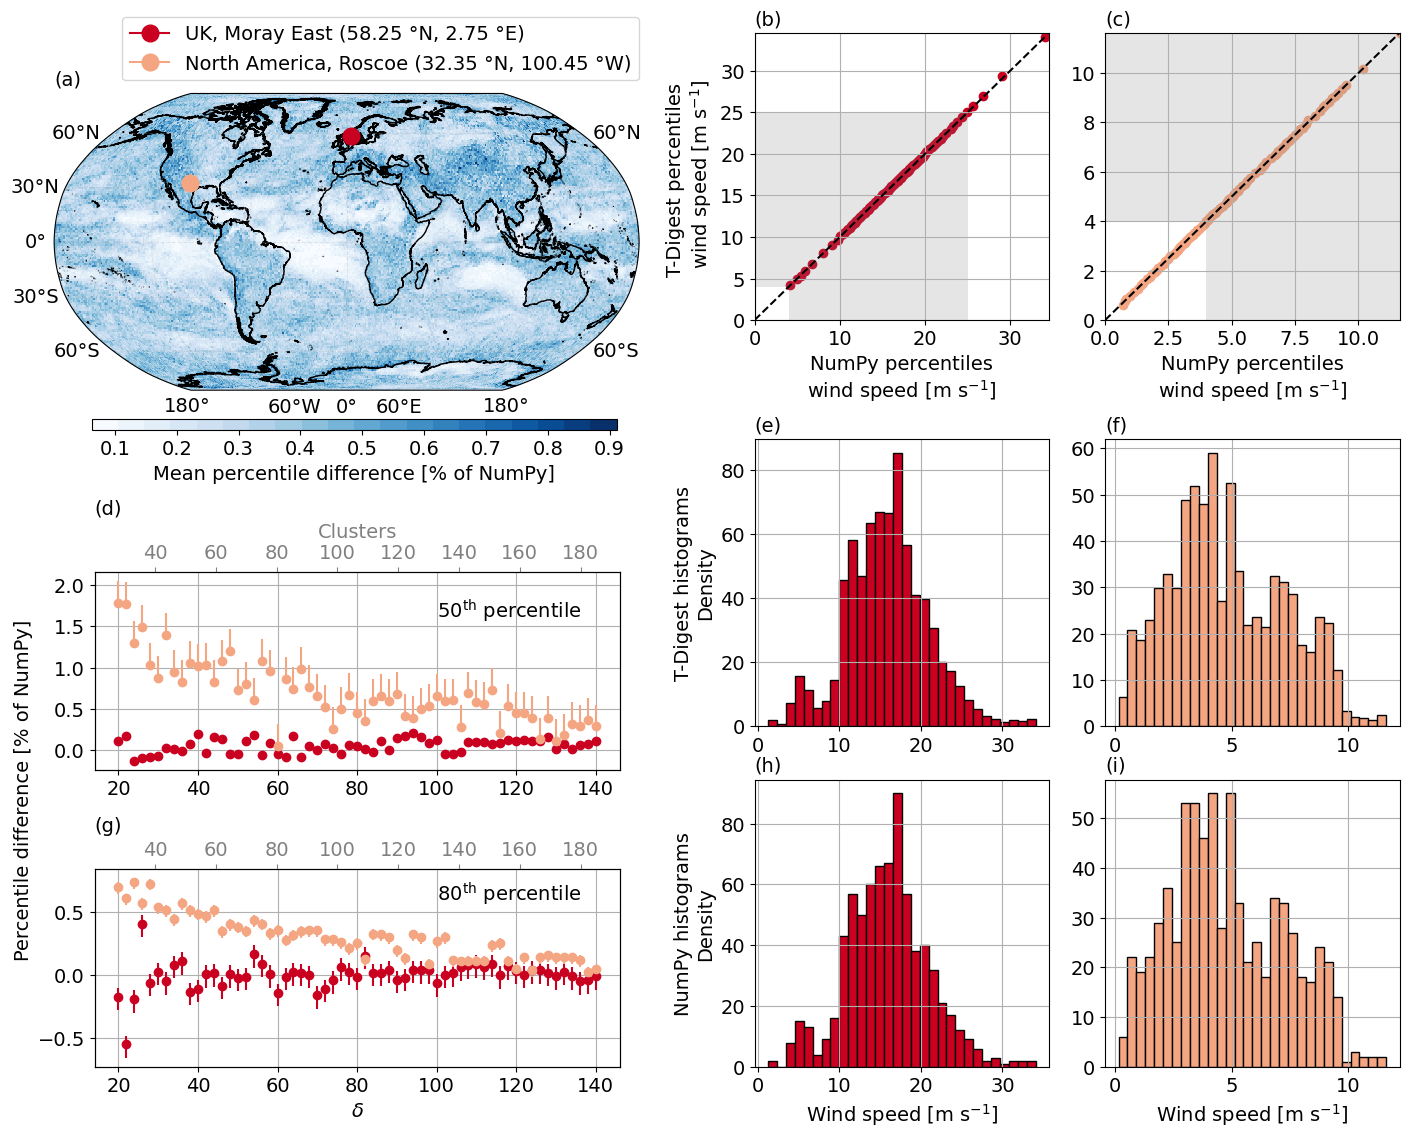

In [11]:
# fontsize
fsize = 14

# size of histogram inserts
ss_hist = 0.1
xp = 0.79
x_shift = 0.035
x_shift2 = 0.02

# compression factor for the histograms is 60 *array index is 20)
comp_index = 20

# defining colours for plotting
colors = (
    '#ca0020',
    '#f4a582',
    '#92c5de',
    '#0571b0',
)

robinson = ccrs.Robinson()

geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,11))
fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.86, wspace = 0.5, hspace = 0.2)
outer = gs.GridSpec(3, 3, wspace=0.2, hspace=0.3, width_ratios=[0.9, 0.45, 0.45])

# ===========
# Subfigure 0
# ===========

# setting the global map
# [left, bottom, width, height]
ax = fig.add_axes([0.023, 0.625, 0.39, 0.39], projection = robinson)

fig.subplots_adjust(bottom=0.05, top=0.99, left=0.01, right=0.9, wspace = 0.2, hspace = 0.4)
ax.coastlines(resolution = '10m')

#meridians and parallels
gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize}
gl.ylabel_style = {'size': fsize}

cmap = plt.get_cmap('Blues', 20)
lon2d, lat2d = np.meshgrid(ws.lon, ws.lat)
cs = ax.pcolormesh(lon2d, lat2d, total_per_error[0,:,:], transform=ccrs.PlateCarree(),cmap=cmap)

lon1 = ws.lon[uk_latlon_index[1]].values
lat1 = ws.lat[uk_latlon_index[0]].values

lon2 = ws.lon[texas_latlon_index[1]].values
lat2 = ws.lat[texas_latlon_index[0]].values

#Transform the coordinates of the rectangles to the projection coordinates
rect1 = robinson.transform_point(lon1, lat1, geodetic)
rect2 = robinson.transform_point(lon2, lat2, geodetic)

ax.plot(rect1[0], rect1[1], color=colors[0], marker='o', markersize=12,
        transform=robinson, label = 'UK, Moray East (58.25 °N, 2.75 °E)')
ax.plot(rect2[0], rect2[1], color=colors[1], marker='o', markersize=12,
    transform=robinson, label = "North America, Roscoe (32.35 °N, 100.45 °W)")
ax.set_title('(a)', fontsize = fsize, loc = 'left')

ax.legend(loc = 'upper left', bbox_to_anchor=(0.1, 1.29), fontsize = fsize)

pos = ax.get_position()
new_pos = [pos.x0, pos.y0-0.02, pos.width, pos.height] 
ax.set_position(new_pos)

# Add color bar for each subplot
cbar_ax = fig.add_axes([0.048, 0.629, 0.35, 0.01])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
#cbar.set_ticks(cbar.get_ticks()[::-1])        
cbar.set_label('Mean percentile difference [% of NumPy]', rotation=0, fontsize = fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.update_ticks()

# ===========
# Subfigure 1
# ===========

# quantile quantile plot for the UK wind farm
percen_digest = np.zeros(100)
percen_np = np.zeros(100)
quantiles = np.linspace(1, 100, 100)
alpha = 0.2
# Create main scatter plot

ax = plt.subplot(outer[1])
pos = ax.get_position()
new_pos = [pos.x0 + x_shift, pos.y0, pos.width, pos.height] 
ax.set_position(new_pos)

ax.set_ylabel('T-Digest percentiles \n wind speed [m s$^{-1}$]', fontsize = fsize)
ax.set_xlabel('NumPy percentiles\nwind speed [m s$^{-1}$]', fontsize = fsize)        
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.grid(True)
ax.set_title('(b)', fontsize = fsize, loc = 'left')

# for each percentile extracting the TDigest and NumPy estimate
for i in range(100):
    percen_digest[i] = tdigest_list_uk[comp_index].quantile(quantiles[i]/100)
    percen_np[i] = np.percentile(ws_uk, q = quantiles[i])

text_height = 0.9*np.max(percen_digest)
ax.scatter(percen_np, percen_digest, color=colors[0])
# adding the x = y line 
x_values = np.linspace(0,np.max(ws_uk),100)
y_values = x_values
ax.plot(x_values, y_values, label='x = y', linestyle="--", color='black')

# adding gray patches to show range of wind farm operating speeds
x_start, x_end = 4, 25
y_bottom, y_top = 0, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)
x_start, x_end = 0, 4
y_bottom, y_top = 4, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)  
ax.set_xlim([0,np.max(percen_np)+0.5])      
ax.set_ylim([0,np.max(percen_digest)+0.5])
 
# ===========
# Subfigure 2
# ===========

# quantile quantile plot for the Texas wind farm
ax = plt.subplot(outer[2])
pos = ax.get_position()
new_pos = [pos.x0 + x_shift2, pos.y0, pos.width, pos.height] 
ax.set_position(new_pos)

percen_digest = np.zeros(100)
percen_np = np.zeros(100)

ax.set_xlabel('NumPy percentiles\nwind speed [m s$^{-1}$]', fontsize = fsize)        
#ax.set_ylabel(r'T-Digest percentiles - wind speed [m s$^{-1}$]', fontsize = fsize)
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.grid(True)
ax.set_xlim([0, np.max(ws_texas)])
ax.set_ylim([0, np.max(ws_texas)])
ax.set_title('(c)', fontsize = fsize, loc = 'left')

# extracting the TDigest and NumPy percentile estimates
for i in range(100):
    percen_digest[i] = tdigest_list_texas[comp_index].quantile(quantiles[i]/100)
    percen_np[i] = np.percentile(ws_texas, q = quantiles[i])

ax.scatter(percen_np, percen_digest, color=colors[1])
text_height = 0.9*np.max(percen_digest)

# adding x = y line
ax.plot(x_values, y_values, label='x = y', linestyle="--", color='black')

# adding gray patches to show range of wind farm operating speeds
x_start, x_end = 4, 25
y_bottom, y_top = 0, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)

x_start, x_end = 0, 4
y_bottom, y_top = 4, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)

# ===========
# Subfigure 3
# ===========
    
# 50th and 80th percentile errors as a function of compression
# factors to get the correct location
ss = 0.175
extra = 0.005

ax = fig.add_axes([0.05, 0.32, ss*2, ss+extra])  # [left, bottom, width, height]
ax.errorbar(compressions, errors_p[0, :,0], yerr = errors_bars_p[0:2, :,0], marker = 'o', color=colors[0],linestyle='')
ax.errorbar(compressions, errors_p[1, :,0], yerr = errors_bars_p[2:4, :,0], marker = 'o', color=colors[1],linestyle='')
obh = ax.set_ylabel('Percentile difference [% of NumPy]', fontsize = fsize, labelpad = 15)
obh.set_position((0, -0.1))  # Adjust the position tuple as needed

ax.grid(True)
text_height = 0.9*np.max(errors_p[1, :, 0])
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.text(100, text_height, r'50$^{\text{th}}$ percentile', fontsize = fsize)
ax.set_title('(d)', fontsize = fsize, loc = 'left')
#Create a second x-axis sharing the same x-axis
ax2 = ax.twiny()
ax2.scatter(centroid_num_uk[:], errors[0,:,0], color='gray', marker = '')
ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
ax2.tick_params('x', colors='gray', labelsize = fsize)

text_height = 0.8*np.max(errors_p[1, :, 1])
ax = fig.add_axes([0.05, 0.05, ss*2, ss+extra])  # [left, bottom, width, height]
ax.errorbar(compressions, errors_p[0, :, 1], yerr = errors_bars_p[0:2, :,1], marker = 'o', color=colors[0],linestyle='')
ax.errorbar(compressions, errors_p[1, :, 1], yerr = errors_bars_p[2:4, :,1]*2, marker = 'o', color=colors[1],linestyle='')
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.text(100, text_height, r'80$^{\text{th}}$ percentile', fontsize = fsize)
ax.set_xlabel(r'$\delta$', fontsize = fsize)
ax.grid(True)
ax.set_title('(g)', fontsize = fsize, loc = 'left')
ax2 = ax.twiny()
ax2.scatter(centroid_num_uk[:], errors[0, :, 0], color='gray', marker = '')
ax2.tick_params('x', colors='gray', labelsize = fsize)

# ===========
# Subfigure 4
# ===========

# adding the histograms
bins_space = 30
counts, bins = tdigest_list_uk[comp_index].histogram(bins_space)
# Create inset axes for the histogram
ax_hist = plt.subplot(outer[4])
pos = ax_hist.get_position()
new_pos = [pos.x0 + x_shift, pos.y0-0.03, pos.width, pos.height] 
ax_hist.set_position(new_pos)
ax_hist.hist(bins[:-1], bins=bins, weights=counts, color=colors[0], edgecolor='black', alpha = 1)
ax_hist.set_ylabel('T-Digest histograms\nDensity', fontsize = fsize)
ax_hist.tick_params('y', labelsize = fsize)
ax_hist.tick_params('x', labelsize = fsize)
ax_hist.grid(True)
ax_hist.set_title('(e)', fontsize = fsize, loc = 'left')

# ===========
# Subfigure 5
# ===========

counts, bins = tdigest_list_texas[comp_index].histogram(bins_space)

#Create inset axes for the histogram
ax_hist = plt.subplot(outer[5])
pos = ax_hist.get_position()
new_pos = [pos.x0 + x_shift2, pos.y0-0.03, pos.width, pos.height] 
ax_hist.set_position(new_pos)

ax_hist.hist(bins[:-1], bins = bins, weights = counts, color = colors[1], edgecolor='black', alpha = 1)

ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
ax_hist.xaxis.set_label_coords(0.4, -0.3)  
#ax_hist.set_ylabel('Density', fontsize = fsize)
ax_hist.tick_params('y', labelsize = fsize)
ax_hist.tick_params('x', labelsize = fsize)
ax_hist.grid(True)
ax_hist.set_title('(f)', fontsize = fsize, loc = 'left')

# ===========
# Subfigure 7
# ===========

# adding the histograms
bins_space = 30
_, bins = tdigest_list_uk[comp_index].histogram(bins_space)

# Create inset axes for the histogram
ax_hist = plt.subplot(outer[7])
pos = ax_hist.get_position()
new_pos = [pos.x0 + x_shift, pos.y0, pos.width, pos.height] 
ax_hist.set_position(new_pos)

ax_hist.hist(ws_uk.flatten(), bins=bins, color=colors[0], edgecolor='black')
ax_hist.set_ylabel('NumPy histograms\nDensity', fontsize = fsize)
ax_hist.tick_params('y', labelsize = fsize)
ax_hist.tick_params('x', labelsize = fsize)
ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
ax_hist.grid(True)
ax_hist.set_title('(h)', fontsize = fsize, loc = 'left')

# ===========
# Subfigure 8
# ===========

_, bins = tdigest_list_texas[comp_index].histogram(bins_space)

#Create inset axes for the histogram
ax_hist = plt.subplot(outer[8])
pos = ax_hist.get_position()
new_pos = [pos.x0 + x_shift2, pos.y0, pos.width, pos.height] 
ax_hist.set_position(new_pos)

ax_hist.hist(ws_texas.flatten(), bins=bins, color=colors[1], edgecolor='black')
ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
#ax_hist.xaxis.set_label_coords(0.4, -0.3)  
#ax_hist.set_ylabel('Density', fontsize = fsize)
ax_hist.tick_params('y', labelsize = fsize)
ax_hist.tick_params('x', labelsize = fsize)
ax_hist.grid(True)
ax_hist.set_title('(i)', fontsize = fsize, loc = 'left')

        
plt.show()